I will create an AI that predict S&P 500 index

Imorting and initialization the project 

In [1]:
import yfinance as yf 

Using the Ticker class to download S&P 500 history using the GSPC sympol 

In [2]:
sp500 = yf.Ticker("^GSPC")

query the S&P 500 index from the beginning of this stock 

In [3]:
sp500 = sp500.history(period="max")

In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-01-17 00:00:00-05:00,5995.399902,6014.959961,5978.439941,5996.660156,4366830000,0.0,0.0
2025-01-21 00:00:00-05:00,6014.120117,6051.509766,6006.879883,6049.240234,4702920000,0.0,0.0
2025-01-22 00:00:00-05:00,6081.390137,6100.810059,6076.129883,6086.370117,4323040000,0.0,0.0


Plot the closing price against the index (The trading days)

<Axes: xlabel='Date'>

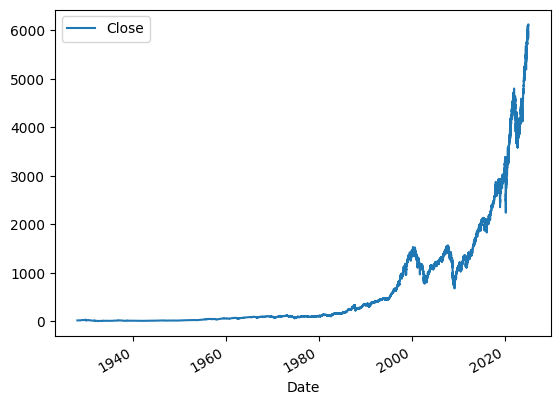

In [6]:
sp500.plot.line(y="Close", use_index=True)

Removing the columns that are appropriate for individual stocks not index

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]